# **CSC 215 project 2**
## BY Sirish Prabakar and Dane Jew

# Time Series Forecasting using NN, LSTM, and CNN

In [1]:
%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    

preprocess = True

filename_read = os.path.join(r"C:\Users\siris\OneDrive\Desktop\215\mini-project2\CSC215_P2_Stock_Price.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('Date', axis=1, inplace=True)
df.drop('Adj_Close', axis=1, inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'Open')
    encode_numeric_zscore(df, 'High')
    encode_numeric_zscore(df, 'Low')
    encode_numeric_zscore(df, 'Volume')

    
x,y = to_xy(df,'Close')
encode_numeric_zscore(df, 'Close')
y2=df.Close

y2=y2.values.astype(np.float32)
x=np.concatenate((x, y[:,None]), 1)

# Main feature 1: Fully Connected Neural Network 

# For fully connected neural network we found the best combination of paramaters to be:
## • **1. ACTIVATION :**            : relu(best)
##                                  : tanh didnt turn out to be a good option since tanh activation layers caused the F-1 score to drop 
##                                  : sigmoid didnt turn out be a good option since sigmoid activation layers caused the F-1 score to drop 


## • **2. LAYERS AND NEURON COUNT** 
##                           : Had minimal effect on F-1 score. But however increasing number of layers and nodes resulted in very small increase(negligible) in F-1 score for this dataset.
##                                  : Even with minimal layers and minimal number of nodes this dataset gave us almost a perfect F-1 score.So increasing number of layer/nodes didnt have a                                         noticable impact on the F-1 score.We went with the input layer 20 neurons and intermediate layer having 10 neurons.       


## • **3. OPTIMIZER:**              : adam (best)
##                                  : sgd is not a good option. F1 score obtained by sgd keeping other parameters same, caused the F-1 score to drop.


## The following Trials will show and compare efficiency of the other parameters to confirm the above stated best combination.

# For the above reasons we will continue to use relu and adam in the following modules including extra features.

## Preprocessing

In [2]:

last = y.shape[0]
i = 0
#X_Row = np.concatenate((x[i],y[i]), axis=None)
X_Row = x[i]
for j in range(1,7):
    X_Row = np.concatenate((X_Row, x[i+j]), axis=None)
X = X_Row
Y = y[7]
i = i + 1

while i < (last-7):
    X_Row = x[i]
    for j in range(1,7):
        X_Row = np.concatenate((X_Row, x[i+j]), axis=None)
    X = np.vstack((X, X_Row))
    Y = np.concatenate((Y, y[i+7]), axis=None)    
    i = i + 1

x_train, x_test, y_train, y_test = train_test_split(X , Y , test_size=0.30, random_state=42)
import tensorflow as tf
tf.__version__



'2.1.0'

## Model for Fully Connected Neural Network

In [3]:
checkpointer = ModelCheckpoint(filepath=r"C:\Users\siris\OneDrive\Desktop\215\mini-project2\best_weights.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(40, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
     # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
print('Training finished...Loading the best model')  
print()
model.load_weights(r"C:\Users\siris\OneDrive\Desktop\215\mini-project2\best_weights.hdf5") # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)


#pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)


0
Train on 3069 samples, validate on 1316 samples
Epoch 1/1000
3069/3069 - 1s - loss: 660.3991 - val_loss: 12.0344
Epoch 2/1000
3069/3069 - 0s - loss: 14.9470 - val_loss: 3.7778
Epoch 3/1000
3069/3069 - 0s - loss: 2.4868 - val_loss: 1.6842
Epoch 4/1000
3069/3069 - 0s - loss: 1.7464 - val_loss: 1.3487
Epoch 5/1000
3069/3069 - 0s - loss: 1.4579 - val_loss: 1.3549
Epoch 6/1000
3069/3069 - 0s - loss: 1.4252 - val_loss: 1.3187
Epoch 7/1000
3069/3069 - 0s - loss: 1.3883 - val_loss: 1.3396
Epoch 8/1000
3069/3069 - 0s - loss: 1.3771 - val_loss: 1.2522
Epoch 9/1000
3069/3069 - 0s - loss: 1.3520 - val_loss: 1.2379
Epoch 10/1000
3069/3069 - 0s - loss: 1.2907 - val_loss: 1.2059
Epoch 11/1000
3069/3069 - 0s - loss: 1.2418 - val_loss: 1.2698
Epoch 12/1000
3069/3069 - 0s - loss: 1.2483 - val_loss: 1.1943
Epoch 13/1000
3069/3069 - 0s - loss: 1.2738 - val_loss: 1.1830
Epoch 14/1000
3069/3069 - 0s - loss: 1.3104 - val_loss: 1.1626
Epoch 15/1000
3069/3069 - 0s - loss: 1.1771 - val_loss: 1.1543
Epoch 16/1

## Results for FCNN

Score (RMSE): 0.9317330121994019


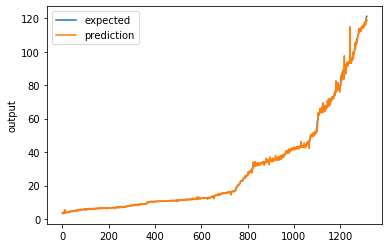

In [4]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)


# Main feature 2: LSTM

## Preprocessing

In [39]:

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)    


# ************************
# Format Data by Dimensions
# Dimensions N X 7 X 5

last = y.shape[0]

i = 0
X_Row = x[i:i+7]
X = X_Row
Y = y[i+7]

i = i + 1
while i < (last-7):
    X_Row = x[i:i+7]
    X = np.vstack((X, X_Row))
    Y = np.concatenate((Y, y[i+7]), axis=None)    
    i = i + 1

z_dim = int(X.shape[0] / 7)
rowsize = int(z_dim * 7)
X = X[:rowsize]
X = X.reshape((z_dim, 7, 5))

x_train, x_test, y_train, y_test = train_test_split(X , Y , test_size=0.30, random_state=42)

x_train.shape


(3069, 7, 5)

## Model for LSTM

In [14]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

#checkpointer = ModelCheckpoint(filepath=r"data/best_weights_lstm.hdf5", verbose=0, save_best_only=True)
#for i in range(5):
print(i)
print('Build model...')
model = Sequential()
model.add(LSTM(140, dropout=0.01, recurrent_dropout=0.1, input_shape=(7, 5)))
model.add(Dense(35, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2, epochs=50)  
print('Training finished...Loading the best model')  
print()

#model.load_weights(r"data/best_weights_lstm.hdf5") # load weights from best model



4385
Build model...
Train...
Train on 3069 samples, validate on 1316 samples
Epoch 1/50
3069/3069 - 19s - loss: 760.5492 - val_loss: 288.2080
Epoch 2/50
3069/3069 - 9s - loss: 143.8262 - val_loss: 41.3332
Epoch 3/50
3069/3069 - 9s - loss: 23.3064 - val_loss: 18.4498
Epoch 4/50
3069/3069 - 8s - loss: 14.8959 - val_loss: 12.1629
Epoch 5/50
3069/3069 - 9s - loss: 12.9159 - val_loss: 8.9480
Epoch 6/50
3069/3069 - 9s - loss: 10.6878 - val_loss: 8.3820
Epoch 7/50
3069/3069 - 8s - loss: 9.6518 - val_loss: 8.6667
Epoch 8/50
3069/3069 - 9s - loss: 11.1413 - val_loss: 5.9131
Epoch 9/50
3069/3069 - 9s - loss: 5.4204 - val_loss: 2.3751
Epoch 10/50
3069/3069 - 9s - loss: 4.1363 - val_loss: 3.4254
Epoch 11/50
3069/3069 - 9s - loss: 3.3841 - val_loss: 2.1445
Epoch 12/50
3069/3069 - 9s - loss: 3.1358 - val_loss: 1.8488
Epoch 13/50
3069/3069 - 9s - loss: 3.2799 - val_loss: 2.4895
Epoch 14/50
3069/3069 - 8s - loss: 2.9419 - val_loss: 1.4608
Epoch 15/50
3069/3069 - 9s - loss: 2.6192 - val_loss: 1.5731
Ep

Score (RMSE): 1.1759111881256104


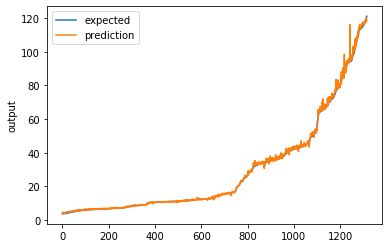

In [15]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

# Main feature 3: Convolution Neural Network

## Preprocessing

In [45]:
import tensorflow as tf
import os
%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
batch_size = 128

filename_read = os.path.join(r"C:\Users\siris\OneDrive\Desktop\215\mini-project2\CSC215_P2_Stock_Price.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('Date', axis=1, inplace=True)
df.drop('Adj_Close', axis=1, inplace=True)

x,y = to_xy(df,'Close')
y2=df.Close
y2=y2.values.astype(np.float32)
x=np.concatenate((x, y[:,None]), 1)
x

array([[3.812500e+00, 4.156250e+00, 3.812500e+00, 3.675600e+06,
        4.125000e+00],
       [4.125000e+00, 4.125000e+00, 4.000000e+00, 1.077600e+06,
        4.015625e+00],
       [4.000000e+00, 4.031250e+00, 3.953125e+00, 4.372000e+05,
        4.000000e+00],
       ...,
       [1.120300e+02, 1.124900e+02, 1.102500e+02, 2.136700e+06,
        1.122300e+02],
       [1.124600e+02, 1.129000e+02, 1.120000e+02, 1.251600e+06,
        1.123400e+02],
       [1.123000e+02, 1.147900e+02, 1.120100e+02, 1.611700e+06,
        1.131900e+02]], dtype=float32)

In [46]:
i = 0
X_Row = x[i:i+7]
X = X_Row
Y = y[i+7]
x

array([[3.812500e+00, 4.156250e+00, 3.812500e+00, 3.675600e+06,
        4.125000e+00],
       [4.125000e+00, 4.125000e+00, 4.000000e+00, 1.077600e+06,
        4.015625e+00],
       [4.000000e+00, 4.031250e+00, 3.953125e+00, 4.372000e+05,
        4.000000e+00],
       ...,
       [1.120300e+02, 1.124900e+02, 1.102500e+02, 2.136700e+06,
        1.122300e+02],
       [1.124600e+02, 1.129000e+02, 1.120000e+02, 1.251600e+06,
        1.123400e+02],
       [1.123000e+02, 1.147900e+02, 1.120100e+02, 1.611700e+06,
        1.131900e+02]], dtype=float32)

In [47]:
i = i + 1
while i < (last-7):
    X_Row = x[i:i+7]
    X = np.vstack((X, X_Row))
    Y = np.concatenate((Y, y[i+7]), axis=None)    
    i = i + 1
    
z_dim = int(X.shape[0] / 7)
rowsize = int(z_dim * 7)
X = X[:rowsize]
X = X.reshape((z_dim,7, 5))

In [48]:
    

x_train = X.reshape(X.shape[0],1,7,5)
x_test = X.reshape(X.shape[0],1,7,5)
x_train.shape


(4385, 1, 7, 5)

In [49]:
x_train=x_train[0:3069]
print(x_train.shape)

x_test=x_test[3069:4385]
print(x_test.shape)

y_train=Y[0:3069]
y_test=Y[3069:4385]


print(y_train.shape)

print(y_test.shape)
y_train

(3069, 1, 7, 5)
(1316, 1, 7, 5)
(3069,)
(1316,)


array([ 3.484375,  3.578125,  3.609375, ..., 45.27    , 48.44    ,
       48.76    ], dtype=float32)

In [50]:
y_test

array([ 50.33,  51.24,  50.94, ..., 112.23, 112.34, 113.19], dtype=float32)

In [51]:

print(x_train.shape)
print(x_test.shape)
y_train=y_train.astype('float32')
y_test=y_test.astype('float32')



(3069, 1, 7, 5)
(1316, 1, 7, 5)


In [52]:
x_train.dtype

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


# normalize the data values to the range [0, 1]
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))
x_train[1]

x_train shape: (3069, 1, 7, 5)
x_test shape: (1316, 1, 7, 5)
Training samples: 3069
Test samples: 1316


array([[[1.6176471e-02, 1.6176471e-02, 1.5686275e-02, 4.2258823e+03,
         1.5747549e-02],
        [1.5686275e-02, 1.5808824e-02, 1.5502451e-02, 1.7145098e+03,
         1.5686275e-02],
        [1.5686275e-02, 1.5686275e-02, 1.5073529e-02, 7.3866665e+03,
         1.5073529e-02],
        [1.4644608e-02, 1.4644608e-02, 1.3296569e-02, 3.1104314e+04,
         1.3296569e-02],
        [1.3725490e-02, 1.4522059e-02, 1.3480392e-02, 4.5046273e+04,
         1.3480392e-02],
        [1.3848039e-02, 1.4031863e-02, 1.2132353e-02, 5.1516863e+04,
         1.3725490e-02],
        [1.3602941e-02, 1.3970588e-02, 1.3541667e-02, 2.4900393e+04,
         1.3664216e-02]]], dtype=float32)

In [53]:
print(y_train.shape)
print(y_train[0:10])
input_shape = (1,7,5)
y_train


(3069,)
[3.484375 3.578125 3.609375 3.640625 3.578125 3.578125 3.613275 3.609375
 3.5625   3.515625]


array([ 3.484375,  3.578125,  3.609375, ..., 45.27    , 48.44    ,
       48.76    ], dtype=float32)

## Model for CNN

In [54]:
from tensorflow.keras.layers import Activation, BatchNormalization
import os, glob, sys, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Activation, BatchNormalization, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
import math
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import models, layers, optimizers  

checkpointer = ModelCheckpoint(filepath=r"C:\Users\siris\OneDrive\Desktop\215\mini-project2\best_weights6.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    print(i)
    model = Sequential()


    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=input_shape)) 
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model.add(Dropout(0.1)) 
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(1))
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=adam, metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=8, verbose=1, mode='auto')
    print('Train...')

    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128,callbacks=[monitor],verbose=2, epochs=200) 

print('Training finished...Loading the best model')  
print()

model.summary()

0
Train...
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 1s - loss: 63476.7970 - accuracy: 0.0000e+00 - val_loss: 5993.8772 - val_accuracy: 0.0000e+00
Epoch 2/200
3069/3069 - 0s - loss: 8928.3209 - accuracy: 0.0000e+00 - val_loss: 3226.8326 - val_accuracy: 0.0000e+00
Epoch 3/200
3069/3069 - 0s - loss: 2491.1883 - accuracy: 0.0000e+00 - val_loss: 4423.1663 - val_accuracy: 0.0000e+00
Epoch 4/200
3069/3069 - 0s - loss: 2185.0692 - accuracy: 0.0000e+00 - val_loss: 3957.1063 - val_accuracy: 0.0000e+00
Epoch 5/200
3069/3069 - 0s - loss: 1619.5029 - accuracy: 0.0000e+00 - val_loss: 4256.2004 - val_accuracy: 0.0000e+00
Epoch 6/200
3069/3069 - 0s - loss: 1097.5222 - accuracy: 0.0000e+00 - val_loss: 3888.4853 - val_accuracy: 0.0000e+00
Epoch 7/200
3069/3069 - 0s - loss: 791.1353 - accuracy: 0.0000e+00 - val_loss: 4236.5565 - val_accuracy: 0.0000e+00
Epoch 8/200
3069/3069 - 0s - loss: 847.3503 - accuracy: 0.0000e+00 - val_loss: 4262.3332 - val_accuracy: 0.0000e+00
Epoch 

Test loss: 3805.006548385852
Final score (RMSE): 61.68473815917969


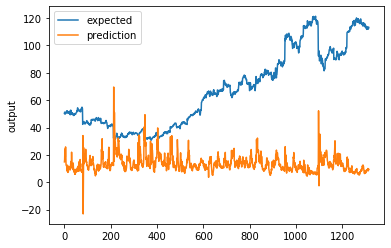

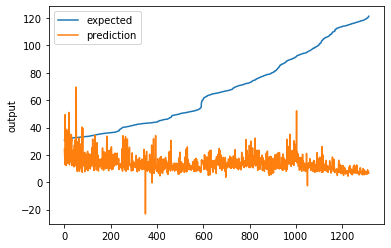

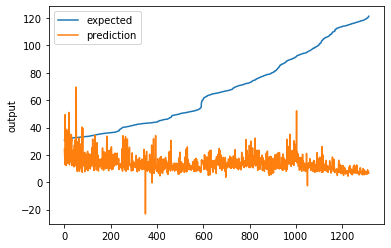

In [55]:
score = model.evaluate(x_test, y_test, verbose=0)
score

print('Test loss: {}'.format(score[0]))
#print('Test accuracy: {}'.format(score[1]))

from sklearn import metrics


pred = model.predict(x_test)

y_true=y_test

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
# Plot the chart
# Plot the chart
chart_regression(pred.flatten(),y_test,sort=False)
chart_regression(pred.flatten(),y_test)
chart_regression(pred.flatten(),y_test, sort=True)

## Using LSTM to Predict the Stock Price for N Days.
## Additional feature

In [18]:
last = y.shape[0]

#N = 4  #1.32
#N = 5  #1.2
N = 6  #1.11
#N = 7  #1.34
#N = 8  #1.40
#N = 9  #1.46
#N = 10  #1.44
#N = 14  #1.34

i = 0
X_Row = x[i:i+N]
X = X_Row
Y = y[i+N]

i = i + 1
while i < (last-N):
    X_Row = x[i:i+N]
    X = np.vstack((X, X_Row))
    Y = np.concatenate((Y, y[i+N]), axis=None)    
    i = i + 1

z_dim = int(X.shape[0] / N)
rowsize = int(z_dim * N)
X = X[:rowsize]
X = X.reshape((z_dim, N, 5))

x_train, x_test, y_train, y_test = train_test_split(X , Y , test_size=0.30, random_state=42)

In [19]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

print('Build model...')
model = Sequential()

model.add(LSTM(140, dropout=0.01, recurrent_dropout=0.1, input_shape=(N, 5)))
model.add(Dense(35, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2, epochs=100)  
print('Training finished...Loading the best model')  
print()


Build model...
Train...
Train on 3070 samples, validate on 1316 samples
Epoch 1/100
3070/3070 - 16s - loss: 880.7719 - val_loss: 320.0127
Epoch 2/100
3070/3070 - 7s - loss: 204.1870 - val_loss: 62.3124
Epoch 3/100
3070/3070 - 7s - loss: 31.1335 - val_loss: 16.6524
Epoch 4/100
3070/3070 - 8s - loss: 17.0169 - val_loss: 11.1151
Epoch 5/100
3070/3070 - 7s - loss: 13.3329 - val_loss: 8.7132
Epoch 6/100
3070/3070 - 7s - loss: 10.4119 - val_loss: 6.0443
Epoch 7/100
3070/3070 - 8s - loss: 6.5835 - val_loss: 2.9008
Epoch 8/100
3070/3070 - 7s - loss: 5.1419 - val_loss: 2.5656
Epoch 9/100
3070/3070 - 8s - loss: 4.3870 - val_loss: 2.5316
Epoch 10/100
3070/3070 - 8s - loss: 4.1752 - val_loss: 1.8596
Epoch 11/100
3070/3070 - 7s - loss: 4.0179 - val_loss: 2.2480
Epoch 12/100
3070/3070 - 8s - loss: 3.3185 - val_loss: 1.6761
Epoch 13/100
3070/3070 - 7s - loss: 3.4828 - val_loss: 1.4435
Epoch 14/100
3070/3070 - 7s - loss: 3.2225 - val_loss: 1.5834
Epoch 15/100
3070/3070 - 8s - loss: 3.0337 - val_loss: 

Score (RMSE): 1.4985431432724


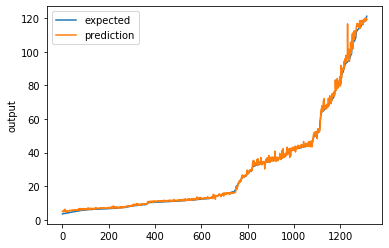

In [20]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)